# 프로젝트 개요
- 강의명 : 2022년 K-디지털 직업훈련(Training) 사업 - AI데이터플랫폼을 활용한 빅데이터 분석전문가 과정
- 교과목명 : 빅데이터 분석 및 시각화, AI개발 기초, 인공지능 프로그래밍
- 프로젝트 주제 : Spaceship Titanic 데이터를 활용한 탑승유무 분류모형 개발
- 프로젝트 마감일 : 2022년 4월 12일 화요일
- 강사명 : 정지훈 강사
- 수강생명 : 황우빈

In [845]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


# Step.1 라이브러리 및 데이터 불러오기
- 라이브러리 버전 확인

In [846]:
import numpy as np
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)

print("success")

success


In [847]:
# 데이터 불러오기
    # PassengerId: 승객 번호, Transported: 전송
sample = pd.read_csv("/kaggle/input/spaceship-titanic/sample_submission.csv")
# print(sample.head())
test = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")
print(test.head())
train = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
print(train.head())

  PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0013_01      Earth      True  G/3/S  TRAPPIST-1e  27.0  False   
1     0018_01      Earth     False  F/4/S  TRAPPIST-1e  19.0  False   
2     0019_01     Europa      True  C/0/S  55 Cancri e  31.0  False   
3     0021_01     Europa     False  C/1/S  TRAPPIST-1e  38.0  False   
4     0023_01      Earth     False  F/5/S  TRAPPIST-1e  20.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck              Name  
0          0.0        0.0           0.0     0.0     0.0   Nelly Carsoning  
1          0.0        9.0           0.0  2823.0     0.0    Lerome Peckers  
2          0.0        0.0           0.0     0.0     0.0   Sabih Unhearfus  
3          0.0     6652.0           0.0   181.0   585.0  Meratz Caltilter  
4         10.0        0.0         635.0     0.0     0.0   Brence Harperez  
  PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRA

## 칼럼 별 설명:
- PassengerId: 각 승객의 고유 ID
- HomePlanet: 승객이 출발한 행성
- CryoSleep: 승객이 항해 기간 동안 애니메이션을 일시 중단하도록 선택했는지 여부를 나타냄
- Cabin: 승객이 머물고 있는 객실 번호입니다.
- Destination: 승객이 출발할 행성입니다.
- Age: 승객의 나이
- VIP: 승객이 항해 중 특별 VIP 서비스 비용을 지불했는지 여부.
- RoomService: 승객이 룸서비스에 대해 청구한 금액입니다.
- Name: 승객의 이름
- Transported: 승객이 다른 차원으로 운송되었는지 여부. 예측하려는 대상인 열

- train데이터 결측치 유무, 통계 확인

In [848]:
train.info()
train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


- test데이터 결측치 유무, 통계 확인

In [849]:
# 결측치 확인
test.info()
test.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,4186.000000,4195.000000,4171.000000,4179.000000,4176.000000,4197.000000
mean,28.658146,219.266269,439.484296,177.295525,303.052443,310.710031
std,14.179072,607.011289,1527.663045,560.821123,1117.186015,1246.994742
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,37.000000,53.000000,78.000000,33.000000,50.000000,36.000000
max,79.000000,11567.000000,25273.000000,8292.000000,19844.000000,22272.000000


# Step.2 탐색적 자료 분석(EDA)
- 데이터 시각화
- 산점도, 막대 그래프 등
- 그래프 해석해서 설명을 달아야 함.
- 약간의 데이터 전처리

- 시각화하기 위한 함수 작성.

In [850]:
def visual(train, test, text):
    
    train_series = train[text].value_counts()
    train_df = pd.DataFrame(train_series).sort_index()
    
    test_series = test[text].value_counts()
    test_df = pd.DataFrame(test_series).sort_index()

    fig = make_subplots(rows= 1,
                       cols= 1,
                       column_titles= ["Target Values"],
                       y_title= "Values")

    fig.add_trace(go.Scatter(x= train_df.index, y= train_df[text],
                        orientation="v",
                            name= "train_data"),
                        1, 1)

    fig.add_trace(go.Scatter(x= test_df.index, y= test_df[text],
                        orientation="v",
                            name= "test_data"),
                        1, 1)          
    fig.update_layout()
    fig.show()

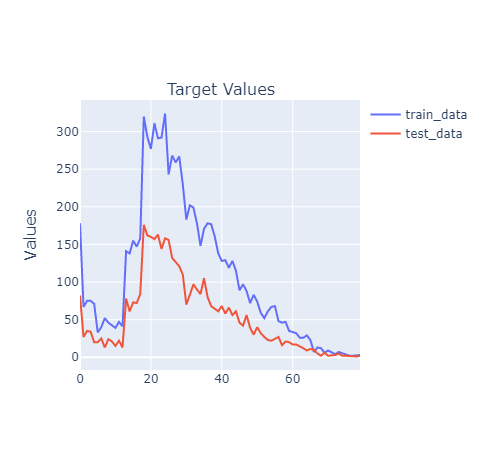

In [851]:
visual(train, test, "Age")

    - 10대 후반에서 30대 후반의 비율이 높은것을 확인 할 수 있음.

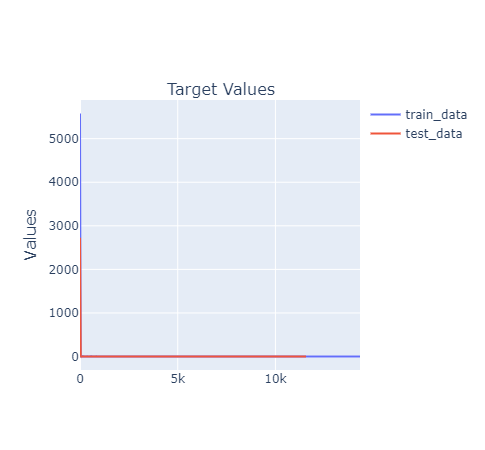

In [852]:
visual(train, test, "RoomService")

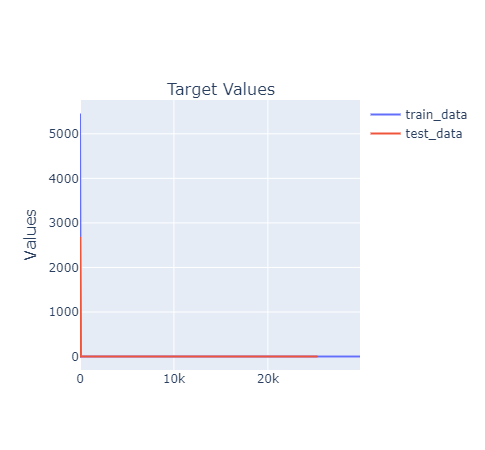

In [853]:
visual(train, test, "FoodCourt")

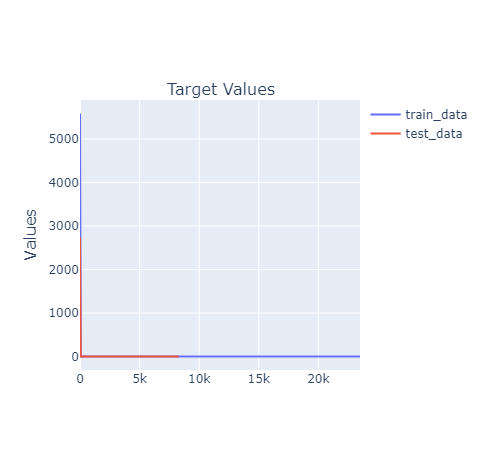

In [854]:
visual(train, test, "ShoppingMall")

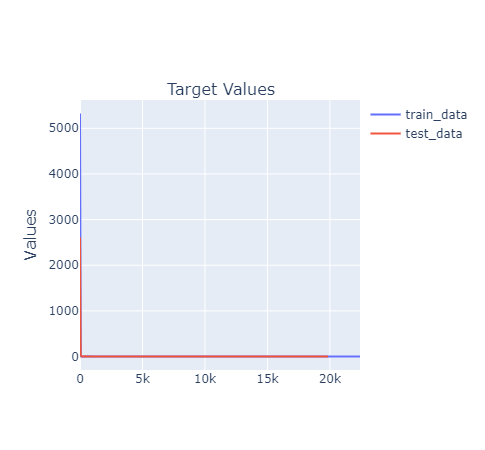

In [855]:
visual(train, test, "Spa")

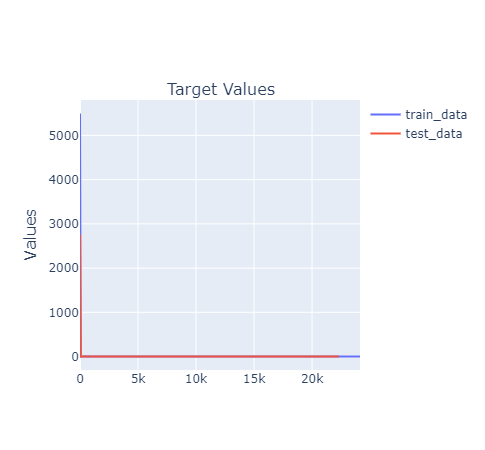

In [856]:
visual(train, test, "VRDeck")

    - RoomService, FoodCourt, ShoppingMall, Spa, VRDeck의 데이터중 10 미만의 값들이 압도적으로 많은것을 확인 할 수 있다.

- 결측값들의 개수 찾기

In [857]:
train_null = pd.DataFrame(train.isna().sum())
train_null= train_null.sort_values(by= 0)
print(train_null)

print()

test_null = pd.DataFrame(test.isna().sum())
test_null= test_null.sort_values(by= 0)
print(test_null)

                0
PassengerId     0
Transported     0
Age           179
RoomService   181
Destination   182
FoodCourt     183
Spa           183
VRDeck        188
Cabin         199
Name          200
HomePlanet    201
VIP           203
ShoppingMall  208
CryoSleep     217

                0
PassengerId     0
VRDeck         80
RoomService    82
HomePlanet     87
Age            91
Destination    92
CryoSleep      93
VIP            93
Name           94
ShoppingMall   98
Cabin         100
Spa           101
FoodCourt     106


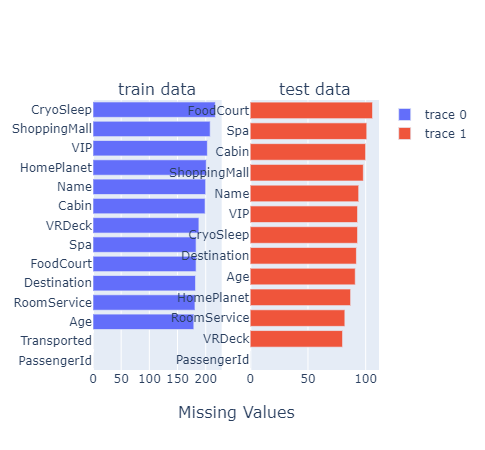

In [858]:
# 결측치데이터 - 시각화
fig = make_subplots(rows= 1,
                   cols= 2,
                   column_titles= ["train data", "test data"],
                   x_title= "Missing Values")

fig.add_trace(go.Bar(x= train_null[0], y= train_null.index,
                    orientation="h",),
                    1, 1)
              
fig.add_trace(go.Bar(x= test_null[0], y= test_null.index,
                    orientation="h"),
                    1, 2)          

fig.update_layout()
fig.show()

    - Transported와 PassengerId를 제외하고는 결측치가 존재하는걸 확인 할 수 있음.

# Step.3 데이터 전처리
- Feature Engineering
- 머신러닝(ML) 모형을 돌리기 위해 표준화 등 / 원핫-인코딩
- 파생변수(도출변수) 만들기
    - 왜 이 변수를 만들었는지에 대한 설명 필요

- 필요한 데이터를 제외하고는 제외

In [859]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [860]:
target = train['Transported']
target

0       False
1        True
2       False
3       False
4        True
        ...  
8688    False
8689    False
8690     True
8691    False
8692     True
Name: Transported, Length: 8693, dtype: bool

In [861]:
print(train['PassengerId'].value_counts())  # x
# train['HomePlanet'].value_counts()  # o
# train['CryoSleep'].value_counts()  # o
print(train['Cabin'].value_counts())  # x
# train['Destination'].value_counts()  # o
# train['Age'].value_counts()  # o
# train['VIP'].value_counts()  # o
# train['RoomService'].value_counts()  # o
# train['FoodCourt'].value_counts()  # o
# train['ShoppingMall'].value_counts()  # o
# train['Spa'].value_counts()  # o
# train['VRDeck'].value_counts()  # o
print(train['Name'].value_counts())  # x

0001_01    1
6136_01    1
6141_01    1
6139_06    1
6139_05    1
          ..
3126_01    1
3124_03    1
3124_02    1
3124_01    1
9280_02    1
Name: PassengerId, Length: 8693, dtype: int64
G/734/S     8
G/109/P     7
B/201/P     7
G/1368/P    7
G/981/S     7
           ..
G/556/P     1
E/231/S     1
G/545/S     1
G/543/S     1
F/947/P     1
Name: Cabin, Length: 6560, dtype: int64
Gollux Reedall        2
Elaney Webstephrey    2
Grake Porki           2
Sus Coolez            2
Apix Wala             2
                     ..
Jamela Griffy         1
Hardy Griffy          1
Salley Mckinn         1
Mall Frasp            1
Propsh Hontichre      1
Name: Name, Length: 8473, dtype: int64


    - 확인 해 본 결과 PassengerId, Name의 특성은 예측에 영향을 안줄것으로 추정하여 제외하도록 함.

In [862]:
train_data = train.drop(['PassengerId', 'Name'], axis= 1)
test_data = test.drop(['PassengerId', 'Name'], axis= 1)

print(train_data.shape)
print(test_data.shape)

(8693, 12)
(4277, 11)


- 결측치를 float 타입은 mean()으로 object 타입은 최빈값으로 채우기 위해 각각의 데이터를 확인
- 'Cabin'특성은 위에 있는 값으로 대체

In [863]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8492 non-null   object 
 1   CryoSleep     8476 non-null   object 
 2   Cabin         8494 non-null   object 
 3   Destination   8511 non-null   object 
 4   Age           8514 non-null   float64
 5   VIP           8490 non-null   object 
 6   RoomService   8512 non-null   float64
 7   FoodCourt     8510 non-null   float64
 8   ShoppingMall  8485 non-null   float64
 9   Spa           8510 non-null   float64
 10  VRDeck        8505 non-null   float64
 11  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(5)
memory usage: 755.7+ KB


In [864]:
# float
print(train_data["Age"].mean())
print(train_data["RoomService"].mean())
print(train_data["FoodCourt"].mean())
print(train_data["ShoppingMall"].mean())
print(train_data["Spa"].mean())
print(train_data["VRDeck"].mean())
# object
print(train_data["HomePlanet"].mode())
print(train_data["CryoSleep"].mode())
print(train_data["Destination"].mode())
print(train_data["VIP"].mode())
print(train_data["Cabin"].value_counts())

28.82793046746535
224.687617481203
458.07720329024676
173.72916912197996
311.1387779083431
304.8547912992357
0    Earth
dtype: object
0    False
dtype: object
0    TRAPPIST-1e
dtype: object
0    False
dtype: object
G/734/S     8
G/109/P     7
B/201/P     7
G/1368/P    7
G/981/S     7
           ..
G/556/P     1
E/231/S     1
G/545/S     1
G/543/S     1
F/947/P     1
Name: Cabin, Length: 6560, dtype: int64


- train데이터 결측값 대체하기

In [865]:
# float
train_data['Age'].replace(np.nan, train_data['Age'].mean(), inplace= True)
train_data['RoomService'].replace(np.nan, train_data['RoomService'].mean(), inplace= True)
train_data['FoodCourt'].replace(np.nan, train_data['FoodCourt'].mean(), inplace= True)
train_data['ShoppingMall'].replace(np.nan, train_data['ShoppingMall'].mean(), inplace= True)
train_data['Spa'].replace(np.nan, train_data['Spa'].mean(), inplace= True)
train_data['VRDeck'].replace(np.nan, train_data['VRDeck'].mean(), inplace= True)
# object
train_data['HomePlanet'].replace(np.nan, 'Earth', inplace= True)
train_data['Destination'].replace(np.nan, 'TRAPPIST-1e', inplace= True)
train_data['CryoSleep'].replace(np.nan, False, inplace= True)
train_data['VIP'].replace(np.nan, False, inplace= True)
train_data['Cabin'].fillna(method= 'ffill', inplace= True)

train_data.isna().sum()

HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Transported     0
dtype: int64

In [866]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    4190 non-null   object 
 1   CryoSleep     4184 non-null   object 
 2   Cabin         4177 non-null   object 
 3   Destination   4185 non-null   object 
 4   Age           4186 non-null   float64
 5   VIP           4184 non-null   object 
 6   RoomService   4195 non-null   float64
 7   FoodCourt     4171 non-null   float64
 8   ShoppingMall  4179 non-null   float64
 9   Spa           4176 non-null   float64
 10  VRDeck        4197 non-null   float64
dtypes: float64(6), object(5)
memory usage: 367.7+ KB


In [867]:
# float
print(test_data["Age"].mean())
print(test_data["RoomService"].mean())
print(test_data["FoodCourt"].mean())
print(test_data["ShoppingMall"].mean())
print(test_data["Spa"].mean())
print(test_data["VRDeck"].mean())
# object
print(test_data["HomePlanet"].mode())
print(test_data["CryoSleep"].mode())
print(test_data["Destination"].mode())
print(test_data["VIP"].mode())

28.65814620162446
219.26626936829558
439.4842963318149
177.29552524527398
303.05244252873564
310.71003097450557
0    Earth
dtype: object
0    False
dtype: object
0    TRAPPIST-1e
dtype: object
0    False
dtype: object


- test데이터 결측값 대체하기

In [868]:
# float
test_data['Age'].replace(np.nan, test_data['Age'].mean(), inplace= True)
test_data['RoomService'].replace(np.nan, test_data['RoomService'].mean(), inplace= True)
test_data['FoodCourt'].replace(np.nan, test_data['FoodCourt'].mean(), inplace= True)
test_data['ShoppingMall'].replace(np.nan, test_data['ShoppingMall'].mean(), inplace= True)
test_data['Spa'].replace(np.nan, test_data['Spa'].mean(), inplace= True)
test_data['VRDeck'].replace(np.nan, test_data['VRDeck'].mean(), inplace= True)
# object
test_data['HomePlanet'].replace(np.nan, 'Earth', inplace= True)
test_data['Destination'].replace(np.nan, 'TRAPPIST-1e', inplace= True)
test_data['CryoSleep'].replace(np.nan, False, inplace= True)
test_data['VIP'].replace(np.nan, False, inplace= True)
test_data['Cabin'].fillna(method= 'ffill', inplace= True)

test_data.isna().sum()

HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
dtype: int64

     - 결측값들 성공적으로 제거!

- Cabin 데이터를 숫자와 문자로 분리

In [869]:
train_data['Cabin_fir']= 0
train_data['Cabin_sec']= 0

test_data['Cabin_fir']= 0
test_data['Cabin_sec']= 0

for i in range(0, len(train_data)):
    strain_data = train_data['Cabin'][i].split("/")
    train_data['Cabin_fir'][i]= strain_data[0]+ strain_data[2]
    train_data['Cabin_sec'][i]= float(strain_data[1])

for i in range(0, len(test_data)):
    strain_data = train_data['Cabin'][i].split("/")
    test_data['Cabin_fir'][i]= strain_data[0]+ strain_data[2]
    test_data['Cabin_sec'][i]= float(strain_data[1])
    
train_data.head()
test_data.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is t

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Cabin_fir,Cabin_sec
0,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,BP,0
1,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,FS,0
2,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,AS,0
3,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,AS,0
4,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,FS,1


In [870]:
train_data= train_data.drop('Cabin', axis= 1)
test_data= test_data.drop('Cabin', axis= 1)

train_data.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Cabin_fir,Cabin_sec
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,BP,0
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,FS,0
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,AS,0
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,AS,0
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,FS,1


## 원핫인코딩

In [871]:
# Transported의 True는 1로, False는 0으로 대체
train_data['Transported'] = train_data['Transported'].map({True: 1, False: 0})
categorical = ['HomePlanet', 'Destination', 'CryoSleep', 'VIP']

transformer = make_column_transformer(
(OneHotEncoder(), categorical),
remainder = 'passthrough')


train_transformed = transformer.fit_transform(train_data[categorical])
train_transformed_df = pd.DataFrame(train_transformed, columns= transformer.get_feature_names_out())
train_data = pd.concat([train_data, train_transformed_df], axis= 1)
train_data = train_data.drop(categorical, axis= 1)

test_transformed = transformer.fit_transform(test_data[categorical])
test_transformed_df = pd.DataFrame(test_transformed, columns= transformer.get_feature_names_out())
test_data = pd.concat([test_data, test_transformed_df], axis= 1)
test_data = test_data.drop(categorical, axis= 1)

print("success")

success


- 라벨 인코딩 해볼 예정
    - Cabin 특성의 문자열은 라벨 인코딩으로 처리 해 봄.

In [872]:
LE = LabelEncoder()

LE.fit(train_data['Cabin_fir'])
train_data['Cabin_fir'] = LE.transform(train_data['Cabin_fir'])

LE.fit(test_data['Cabin_fir'])
test_data['Cabin_fir'] = LE.transform(test_data['Cabin_fir'])

print("성공!")

성공!


# Step.4 머신러닝 모형 개발
- 모형에 대한 설명 필요
- 모형 1~2개 사용 권장
- 교차 검증
- 하이퍼 파라미터 튜닝
    - 랜덤서치(매개변수(max_depth))
    - 그래드서치

- 독립변수와 종속변수를 구분
    - 독립변수: x
    - 종속변수: Transported == y

In [873]:
x_cols = test_data.columns
x = train_data[x_cols].to_numpy()
y = train_data['Transported'].to_numpy()

- 훈련데이터를 검증데이터로 분리
    - 검증데이터: val

In [874]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size= 0.3, random_state= 42)
x_train.shape,x_val.shape,y_train.shape,y_val.shape

((6085, 18), (2608, 18), (6085,), (2608,))

## 랜덤서치

In [875]:
params = {
    'min_impurity_decrease': uniform(0.0001, 0.001),
    'max_depth': randint(20, 50),
    'min_samples_split': randint(2, 25),
    'min_samples_leaf': randint(1, 25),}
gs = RandomizedSearchCV(DecisionTreeClassifier(random_state= 42), params,  # n_iter: 파라미터 검색 횟수
                        n_iter= 100, n_jobs= -1, random_state= 42)  # n_jobs: cpu코어 수

gs.fit(x_train, y_train)

RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fa83fc26050>,
                                        'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fa83ed38a50>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fa83fc26e10>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fa83fc26ed0>},
                   random_state=42)

In [876]:
print(gs.best_params_)

{'max_depth': 41, 'min_impurity_decrease': 0.0004586467812961639, 'min_samples_leaf': 10, 'min_samples_split': 3}


In [877]:
print(np.max(gs.cv_results_['mean_test_score']))

0.7881676253081349


In [878]:
dt = gs.best_estimator_
print(dt.score(x_val, y_val))
print("success")

0.7825920245398773
success


## 교차검증

In [879]:
scores = cross_validate(dt, x_train, y_train)
scores

{'fit_time': array([0.01793003, 0.01694751, 0.01774454, 0.0179069 , 0.01907682]),
 'score_time': array([0.0009532 , 0.0008707 , 0.00083685, 0.00085497, 0.00083208]),
 'test_score': array([0.78882498, 0.7863599 , 0.78718159, 0.77239113, 0.80608053])}

In [880]:
print(np.mean(scores['test_score']))

0.7881676253081349


- StratifiedKFold()로 Fold 교차검증을 높여봄.

In [881]:
scores = cross_validate(dt, x_train, y_train, cv= StratifiedKFold())
print(np.mean(scores['test_score']))

0.7881676253081349


In [882]:
splitter = StratifiedKFold(n_splits=200, shuffle= True, random_state= 42)
scores = cross_validate(dt, x_train, y_train, cv= splitter)
print(np.mean(scores['test_score']))

0.790231182795699


GridSearchCV()의 하이퍼 파라미터를 이용해봄.

In [883]:
params = {'min_impurity_decrease': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005]}

In [884]:
gs = GridSearchCV(DecisionTreeClassifier(random_state= 42),params, n_jobs= -1)
gs.fit(x_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'min_impurity_decrease': [0.0001, 0.0002, 0.0003,
                                                   0.0004, 0.0005]})

- gs로 x,y train데이터 훈련

In [885]:
dt= gs.best_estimator_
print(dt)
print(dt.score(x_train, y_train))
print(gs.best_params_)

DecisionTreeClassifier(min_impurity_decrease=0.0005, random_state=42)
0.8262941659819227
{'min_impurity_decrease': 0.0005}


In [886]:
print(gs.cv_results_['mean_test_score'])

[0.75004108 0.75891537 0.77436319 0.78192276 0.78603122]


- gs로 x,y val데이터 훈련

In [887]:
gs = GridSearchCV(DecisionTreeClassifier(random_state= 42),params, n_jobs= -1)
gs.fit(x_val, y_val)

dt= gs.best_estimator_
print(dt)
print(dt.score(x_val, y_val))
print(gs.best_params_)

DecisionTreeClassifier(min_impurity_decrease=0.0005, random_state=42)
0.9079754601226994
{'min_impurity_decrease': 0.0005}


In [888]:
params = {'min_impurity_decrease': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005],
          'max_depth': range(5, 20, 1),
         'min_samples_split': range(2, 100, 10)}

In [889]:
print(gs.best_params_)

{'min_impurity_decrease': 0.0005}


In [890]:
print(np.max(gs.cv_results_['mean_test_score']))

0.7404188820496981


- LightGBM 사용

In [891]:
lgb = LGBMClassifier(random_state= 42)
lgb

LGBMClassifier(random_state=42)

# Step.5 모형 평가
- 훈련데이터를 쪼개어 훈련데이터 + 검증데이터 분리
- 정확도 비교
- 혼동행렬(confusion Matrix) 설명

- cross_validate() 활용

In [892]:
splitter = StratifiedKFold(n_splits = 5, shuffle = True, random_state=42)
scores = cross_validate(lgb, x_train, y_train, return_train_score = True, cv=splitter)

print("train Acc.", np.mean(scores['train_score']))
print("test Acc.", np.mean(scores['test_score']))

train Acc. 0.9112571898110107
test Acc. 0.810024650780608


- 검증데이터를 활용하여 정확도를 예상해본다.

In [893]:
lgb.fit(x_train, y_train)
y_pred = lgb.predict(x_val)
print("Acc.", accuracy_score(y_val, y_pred))

Acc. 0.8006134969325154


## 혼동행렬 - 오분류 비용

- **나무위키 정의**: 어떤 개인이나 모델, 검사도구, 알고리즘의 '진단', '분류', '판별', '예측'능력을 평가하기 위해 고안된 표. 오류행렬(error matrix)이라고도 하며, 국내에는 오분류표라고 번역되기도 한다.

- 표로 나타내기.

In [894]:
def confusion_matrix():
    col = ["실제로 맞았다  ", "  실제로 틀렸다"]
    ind = ["맞을것이다", "틀릴것이다"]
    con = [["예측 성공", "예측 실패"], ["예측 실패", "예측 성공"]]
    matrix = pd.DataFrame(con, columns=col, index=ind)
    print(matrix)

In [895]:
confusion_matrix()

      실제로 맞았다     실제로 틀렸다
맞을것이다     예측 성공     예측 실패
틀릴것이다     예측 실패     예측 성공


    - True, False 기준에서 작성했기에 2 by 2의 모습
    - 기준을 어떻게 잡느냐에 따라서 3 by 3 이상의 다등급 분류를 나타내는 혼동행렬로 나타낼 수 있다.

# Step.6 제출
- 제출 양식 샘플은 만들어줌.

In [896]:
test_preds = lgb.predict(test_data.to_numpy())
sample['Transported'] = test_preds.astype("bool")
sample.to_csv("submission.csv",index=False)
sample.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


# 참고
- 다른 사람의 code 설명을 쭉 따라치는경우
    - 노트북 표절 방지 위해서, 참조한 코드는 반드시 링크 걸어둘것
    - 저자 이름, 글 제목, 링크 주소

# 마감일
- 4월 12일 17시 40분
- 제출 형태
    - Leaderboard 랭킹 사진 캡처
    - 고용노동부 보고 양식 (다음주에 확인하고 알려주실 예정)

# My_Note
- value_counts(): 값 별 개수 세기
- Pandas라이브러리
    - fillna(): 결측값을 지정한 값으로 채움
    
- clear_output(): 출력값을 지우는 함수. ex) 라이브러리 설치 후 사용
- 리스트[:-1]: 이 리스트의 마지막번째는 제외
- Pandas라이브러리
    - T: 로우와 컬럼을 바꿈
    - sort_values(): 컬럼을 기준으로 정렬 시키는 함수
        - 매개변수 by: 정렬의 기준이 되는 컬럼을 지정
        - 매개변수 asceding: 오름차순(True), 내림차순(False). [default: True]
    - sort_index(): 인덱스(로우)를 기준으로 정렬시키는 함수
    -isna(): 결측값으로 True / False로 구분
- Plotly 패키지
    - make_subplots(): fig(틀)를 잡는 함수.
        - 매개변수 rows: 행의 개수를 지정
        - 매개변수 cols: 열의 개수를 지정
        - 매개변수 x_title: fig(틀)의 x축의 제목을 지정
    - update_layout(): 그래프를 보여주는 함수.
        - 매개변수 showlegend: 각각의 그래프를 보여주고 숨기는 기능 default: True
        - 매개변수 title_x: 알 수 없음
    - go.bar(): 막대 그래프를 그리는 함수
        매개변수 orientation: 위로 향하는("v")그래프를 그릴것인지, 옆으로 향하는("h") 그래프를 그릴것인지 지정. [default: "v"]
    
첫번째 0.78746
두번째 0.76478 cabin fir, sec, thi
세번째 0.76876 cabin side, center
네번째 0.71638 bill_mean
N번째 